In [132]:
# python
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.ndimage import label


# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# thesis library
from lib.functions_scripting import *
from lib.functions_base_analysis import *
from lib.functions_second_analysis import *

from lib.ImageDataset import ImageDataset
from lib.NetworkScorer import NetworkScorer
from lib.PatternGenerator import Pattern_Generator
from lib.ActivationPattern import Activation_Pattern
from lib.transforms import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight import PatternGeneratorSearchlight


PATH_SSINT = os.path.join(PATH_RESULTS, "spatial integration", "subset integration")
PATH_SSIBC = os.path.join(PATH_RESULTS, "spatial integration", "subset ibcorr")
PATH_3DPVAL = os.path.join(PATH_RESULTS, "spatial integration", "subset 3d pvalues")
PATH_3DCORR = os.path.join(PATH_RESULTS, "spatial integration", "subset 3d correlation")
PATH_PERMDISTR = os.path.join(
    PATH_RESULTS, "spatial integration", "permutation distributions"
)

beauty_ratings = load_ratings(PATH_RATINGS)
modelorder = pd.read_pickle(os.path.join(PATH_RESULTS, "model order.pkl"))
BLOCKING_GROUPS = np.insert(np.repeat(range(1, 16 + 1), 3), 0, 0)

In [2]:
_models = modelorder[10:].index.to_list()
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES[:4]

In [3]:
# unblocked data
_blocking = "unblocked"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

# best predicting models & layers

In [140]:
bestlayers = (
    dfibc.groupby(["model", "study", "scale"])
    .agg(corr=("ibcorr", max), layer=("ibcorr", lambda x: x.idxmax()[-1]))
    .reorder_levels(["scale", "study", "model"])
    .sort_index()
).loc[(_scales, _studies, _models)]


laysize_table = pd.DataFrame(np.nan, index=range(48 + 1), columns=["layersize"])
for i in np.diff(BLOCKING_GROUPS).nonzero()[0]:
    laysize_table.loc[i:] = get_layer_size(i)

bestlayers = bestlayers.assign(
    laysize=bestlayers.layer.transform(
        lambda x: laysize_table.loc[x].values[0].astype(int)
    )
)
bestlayers

corr  layer  laysize
scale   study              model                                     
scale2  short presentation class_scene       0.374823     17    65536
                           egomotion         0.205430      6    16384
                           autoencoding      0.045450     40   262144
                           reshading         0.405152     20    65536
                           edge_occlusion    0.321020     32   262144
...                                               ...    ...      ...
scale16 oasis              jigsaw            0.166900      3    16384
                           segment_unsup25d  0.186501     26   262144
                           point_matching    0.088931      1     9408
                           keypoints2d       0.153323     15    65536
                           vanishing_point   0.176404      3    16384

[208 rows x 3 columns]

scale 2: reshading(20) 

In [204]:
bestlayers.loc[("scale2", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(3)

corr  layer  laysize
study              model                                    
short presentation vanishing_point  0.347481     28   262144
                   class_scene      0.374823     17    65536
                   reshading        0.405152     20    65536
long presentation  vanishing_point  0.302165     28   262144
                   class_scene      0.335656     17    65536
                   reshading        0.377791     20    65536
complexity order   vanishing_point  0.353357     18    65536
                   reshading        0.366724     20    65536
                   class_scene      0.386800     17    65536
oasis              reshading        0.160978     20    65536
                   vanishing_point  0.187504      6    16384
                   segment_unsup2d  0.188171      9    16384

scale 4: segment_unsup2d(41)

In [10]:
bestlayers.loc[("scale4", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(5)

corr  layer  laysize
study              model                                     
short presentation segment_unsup25d  0.413453     36   262144
                   vanishing_point   0.422424     28   262144
                   keypoints3d       0.422735     41   262144
                   edge_occlusion    0.428372     32   262144
                   segment_unsup2d   0.464074     41   262144
long presentation  keypoints3d       0.391302     41   262144
                   vanishing_point   0.392898     28   262144
                   edge_occlusion    0.399783     32   262144
                   reshading         0.411068     38   262144
                   segment_unsup2d   0.441788     41   262144
complexity order   segment_unsup2d   0.403273     35   262144
                   edge_occlusion    0.407059     32   262144
                   segment_unsup25d  0.429413     35   262144
                   keypoints3d       0.441996     41   262144
                   reshading         0.454562     46  1048576
oasis              reshading         0.173703     26   262144
                   jigsaw            0.184901      9    16384
                   vanishing_point   0.192614      6    16384
                   segment_unsup25d  0.214946     20    65536
                   segment_unsup2d   0.217433     16    65536

scale 8: vanishing point(18) 

In [12]:
bestlayers.loc[("scale8", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(5)

corr  layer  laysize
study              model                                     
short presentation reshading         0.367198     38   262144
                   edge_occlusion    0.411349     32   262144
                   keypoints3d       0.422174     31   262144
                   segment_unsup25d  0.439146     32   262144
                   vanishing_point   0.440726     18    65536
long presentation  edge_occlusion    0.393943     32   262144
                   segment_unsup25d  0.394273     32   262144
                   keypoints3d       0.395719     32   262144
                   reshading         0.403122     38   262144
                   vanishing_point   0.409139     28   262144
complexity order   keypoints3d       0.379807     41   262144
                   vanishing_point   0.397447     18    65536
                   reshading         0.421284     46  1048576
                   edge_occlusion    0.423733     32   262144
                   segment_unsup25d  0.489717     32   262144
oasis              segment_unsup25d  0.175590     20    65536
                   jigsaw            0.181786      3    16384
                   vanishing_point   0.186468      3    16384
                   reshading         0.187156     47  1048576
                   segment_unsup2d   0.215349     16    65536

scale 16: segment_unsup25d (32) 

In [13]:
bestlayers.loc[("scale16", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(5)

corr  layer  laysize
study              model                                     
short presentation class_scene       0.300790     18    65536
                   edge_occlusion    0.318674     32   262144
                   keypoints3d       0.339122     25   262144
                   segment_unsup25d  0.363642     32   262144
                   vanishing_point   0.386038     28   262144
long presentation  class_scene       0.306167     18    65536
                   keypoints3d       0.308224     25   262144
                   edge_occlusion    0.310564     32   262144
                   vanishing_point   0.338643     28   262144
                   segment_unsup25d  0.342855     32   262144
complexity order   autoencoding      0.289202     25   262144
                   edge_occlusion    0.297022     32   262144
                   keypoints3d       0.353593     25   262144
                   segment_unsup25d  0.376884     32   262144
                   vanishing_point   0.388826     28   262144
oasis              jigsaw            0.166900      3    16384
                   reshading         0.176367     47  1048576
                   vanishing_point   0.176404      3    16384
                   segment_unsup25d  0.186501     26   262144
                   segment_unsup2d   0.189372     16    65536

# localized integration

#### testing

In [165]:
# example study, scale
st = "short presentation"
sc = "scale4"

In [166]:
activation_extractor, layername = setup_singlelayer("vanishing_point", 28)

dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(st), sc))

# init PatternGenerator with activation shape of example image
activation_shape = (
    list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape
)

In [ ]:
pat = PatternGeneratorSearchlight(
    activation_shape,
    layername,
)

num_layers, num_images, num_subsets = 1, dataset.img_count, pat.num_subsets
integration = np.full([num_layers, num_images, num_subsets], np.nan, dtype=np.float64)

for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
    # activations as tensors
    act_full = activation_extractor(img_full)[layername].squeeze()
    act_v1 = activation_extractor(img_v1)[layername].squeeze()
    act_v2 = activation_extractor(img_v2)[layername].squeeze()
    act_avg = (act_v1 + act_v2) / 2.0

    # iterate 3D positions
    pat_it = iter(pat)
    for subset_num, roi_mask in pat_it:
        subset_act_full = act_full[roi_mask]
        subset_act_avg = act_avg[roi_mask]
        # calculate integration and store it
        subset_integration = pearsonr(
            subset_act_full.flatten(), subset_act_avg.flatten()
        )[0]
        integration[:, img_id, subset_num] = subset_integration

In [ ]:
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        st,
        sc + " subsetdata",
        mo + ".hd5",
    ),
    key="integration",
)

In [ ]:
# map to 3d
# load beauty ratings
beauty_ratings = pd.read_csv(
    os.path.join(PATH_RATINGS, study2behaviour(st)), header=None
).mean(axis=1)

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

# convert integration back to 3D layer space
ns = NetworkScorer({layername: activation_shape})
ns.map_back_scores(scores, pat)

In [254]:
tmp = pd.read_hdf(os.path.join(PATH_SUBSETDATA, "scale4 study1 18nets.h5"))

In [ ]:
tmp.index.get_level_values("model").unique()

In [260]:
tmp2 = pd.read_hdf(os.path.join(PATH_SUBSETDATA, "scale4 study3 allnets.h5"))

In [ ]:
tmp.loc[_models]

#### analysis function

In [164]:
from scipy.io import loadmat
import random

class ImageDataset(object):
    """
    Handles preparing images for input into activation extractors:

        - Load images (matlab arrays) from subfolder,
            in alphanumerical order (corresponding to beauty ratings in file).

        - Transform into PyTorch format

    This class provides a iterator to do so.
    """

    def __init__(self, img_dir, beauty_ratings_path=None, subsample=None):

        self.img_dir = img_dir
        self.img_list = sorted(
            list(f for f in os.listdir(os.path.join(img_dir, "full")))
        )
        self.img_count = len(self.img_list)

        if beauty_ratings_path is not None:
            self.beauty_ratings = pd.read_csv(beauty_ratings_path, header=None).mean(
                axis=1
            )

        if subsample != None and beauty_ratings == None:
            raise ValueError("Need to pass beauty_ratings_path when using subsampling!")

        if subsample != None:
            idx = sorted(random.sample(range(len(self.img_list)), subsample))
            self.img_list = [self.img_list[i] for i in idx]
            self.img_count = len(self.img_list)
            self.beauty_ratings = self.beauty_ratings[idx]

    def __iter__(self, transform=lambda x: x):
        self.img_pos = 0
        return self

    def __next__(self):
        if self.img_pos < self.img_count:
            # load arrays (transformed in matlab)
            img_full = loadmat(
                os.path.join(self.img_dir, "full", self.img_list[self.img_pos])
            )["im"]
            img_v1 = loadmat(
                os.path.join(self.img_dir, "version1", self.img_list[self.img_pos])
            )["imv1"]
            img_v2 = loadmat(
                os.path.join(self.img_dir, "version2", self.img_list[self.img_pos])
            )["imv2"]

            # convert to input format of Taskonomy models
            img_full = torch.tensor(img_full).permute([2, 0, 1]).unsqueeze(0)
            img_v1 = torch.tensor(img_v1).permute([2, 0, 1]).unsqueeze(0)
            img_v2 = torch.tensor(img_v2).permute([2, 0, 1]).unsqueeze(0)
            self.img_pos += 1
            return img_full, img_v1, img_v2
        else:  # prepare for a possible next iteration
            self.img_pos = 0
            raise StopIteration

In [ ]:
ImageDataset(os.path.join(PATH_IMAGES, "oasis", "scale2")).beauty_ratings

In [ ]:
def run_spatialintegration_analysis_bestlayer(mo, da, sc, layer_idx):
    # setup best-layer activation extractor
    activation_extractor, layername = setup_singlelayer(mo, layer_idx)

    dataset = ImageDataset(os.path.join(PATH_IMAGES, da, sc))

    # init PatternGenerator with activation shape of example image
    pat = PatternGeneratorSearchlight(
        list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape,
        layername,
    )

    num_layers, num_images, num_subsets = 1, dataset.img_count, pat.num_subsets
    integration = np.full(
        [num_layers, num_images, num_subsets], np.nan, dtype=np.float64
    )

    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        # activations as tensors
        act_full = activation_extractor(img_full)[layername].squeeze()
        act_v1 = activation_extractor(img_v1)[layername].squeeze()
        act_v2 = activation_extractor(img_v2)[layername].squeeze()
        act_avg = (act_v1 + act_v2) / 2.0

        # iterate 3D positions
        pat_it = iter(pat)
        for subset_num, roi_mask in pat_it:
            subset_act_full = act_full[roi_mask]
            subset_act_avg = act_avg[roi_mask]
            # calculate integration and store it
            subset_integration = pearsonr(
                subset_act_full.flatten(), subset_act_avg.flatten()
            )[0]
            integration[:, img_id, subset_num] = subset_integration

    return pd.DataFrame(integration.squeeze().T)

## scale2 reshading(20)

In [ ]:
scale = "scale2"
model = "reshading"
layer = 20

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## scale 4: segment_unsup2d(41)

In [56]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## scale 8: vanishing point(18) 

In [60]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## scale 16: segment_unsup25d (32) 

In [ ]:
scale = "scale16"
model = "segment_unsup25d"
layer = 32

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## randnet
on places1

In [ ]:
dataset = "places1"
model = "randnet"

#### functions

In [4]:
# setup nets for extracting activations from best layer
def setup_singlelayer_randnet(layer_idx: int):
    """Setup activation extractor for a single layer of a random net with
    taskonomy encoder architecture

    """
    randnet = TaskonomyEncoder()
    _, eval_nodes = get_graph_node_names(randnet)
    return_nodes = {node: node for node in eval_nodes if "conv" in node or "fc" in node}

    layer_name = list(return_nodes.keys())[layer_idx]

    return (
        create_feature_extractor(randnet, return_nodes={layer_name: layer_name}),
        layer_name,
    )

In [ ]:
def run_spatialintegration_analysis_singlelayer_randnet(layer):
    activation_extractor, layername = setup_singlelayer_randnet(layer)
    dataset = ImageDataset(os.path.join(PATH_IMAGES, da, sc))

    # init PatternGenerator with activation shape of example image
    pat = PatternGeneratorSearchlight(
        list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape,
        layername,
    )

    # layer x image x subset
    num_layers, num_images, num_subsets = 1, dataset.img_count, pat.num_subsets
    integration = np.full(
        [num_layers, num_images, num_subsets], np.nan, dtype=np.float64
    )

    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        # activations as tensors
        act_full = activation_extractor(img_full)[layername].squeeze()
        act_v1 = activation_extractor(img_v1)[layername].squeeze()
        act_v2 = activation_extractor(img_v2)[layername].squeeze()
        act_avg = (act_v1 + act_v2) / 2.0

        # iterate 3D positions
        pat_it = iter(pat)
        for subset_num, roi_mask in pat_it:
            subset_act_full = act_full[roi_mask]
            subset_act_avg = act_avg[roi_mask]
            # calculate integration and store it
            subset_integration = pearsonr(
                subset_act_full.flatten(), subset_act_avg.flatten()
            )[0]
            integration[:, img_id, subset_num] = subset_integration

    return integration

#### scale 2 (20)

In [ ]:
scale = "scale2"
layer = 20

run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

#### scale 4 (41)

In [ ]:
scale = "scale4"
layer = 41

run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

#### scale 8 (18)

In [ ]:
scale = "scale8"

layer = 18
run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

#### scale16 (32)

In [ ]:
scale = "scale16"
layer = 32

run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
# MAP IBCORR TO 3D SPACE

# load beauty ratings
beauty_ratings = pd.read_csv(
    os.path.join(PATH_RATINGS, study2behaviour(st)), header=None
).mean(axis=1)

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

# convert integration back to 3D layer space
ns = NetworkScorer({layername: activation_shape})
ns.map_back_scores(scores, pat)

## (old) all models

In [ ]:
# # run analysis
# for mo in MODEL_NAMES:
#     print(mo)
#     integration_subsets = run_spatialintegration_analysis_bestlayer(mo, _study, _scale)
#     integration = pd.DataFrame(integration_subsets.squeeze().T)
#     integration.to_hdf(
#         os.path.join(
#             PATH_RESULTS,
#             "spatial integration",
#             _scale,
#             _study + " subsetdata",
#             mo + ".hd5",
#         ),
#         key="integration",
#     )

In [ ]:
# old loading code
# with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), 'rb') as f:
#     integration = np.load(f)

## (old) vanishing_points(28) across scales and studies

In [ ]:
dfibcorr.loc["vanishing_point"].groupby(["study", "scale"]).idxmax()

ibcorr
study              scale                                     
complexity order   scale16    (complexity order, scale16, 28)
                   scale2      (complexity order, scale2, 18)
                   scale32    (complexity order, scale32, 29)
                   scale4      (complexity order, scale4, 18)
                   scale8      (complexity order, scale8, 18)
long presentation  scale16   (long presentation, scale16, 28)
                   scale2     (long presentation, scale2, 28)
                   scale32   (long presentation, scale32, 33)
                   scale4     (long presentation, scale4, 28)
                   scale8     (long presentation, scale8, 28)
oasis              scale16                (oasis, scale16, 3)
                   scale2                  (oasis, scale2, 6)
                   scale32               (oasis, scale32, 25)
                   scale4                  (oasis, scale4, 6)
                   scale8                  (oasis, scale8, 3)
short presentation scale16  (short presentation, scale16, 28)
                   scale2    (short presentation, scale2, 28)
                   scale32  (short presentation, scale32, 29)
                   scale4    (short presentation, scale4, 28)
                   scale8    (short presentation, scale8, 18)

In [ ]:
st = "short presentation"
sc = "scale2"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)

df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        "vanishing_points",
        st + sc + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "complexity order"
sc = "scale2"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "oasis"
sc = "scale2"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "short presentation"
sc = "scale8"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "complexity order"
sc = "scale8"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "oasis"
sc = "scale8"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

# localized ibcorr
take arrays of subset integrations from analysis and correlate with ratings

## testing

In [ ]:
subset_correlations = (
    dfsubsets.loc[_models]
    .apply(
        lambda r: pd.Series(spearmanr(r, beauty_ratings["study3_places2.csv"])), axis=1
    )
    .rename({0: "correlation", 1: "pvalue"}, axis=1)
)

In [ ]:
# in the previous analysis, there conversion from correlation to integration is missing
subset_correlations["correlation"] = -subset_correlations["correlation"]

In [ ]:
# save
subset_correlations.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "subset correlations",
        "study3 scale4 topnets.h5",
    ),
    key="subset correlations",
)

In [77]:
# load
subset_correlations = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "subset correlations",
        "study3 scale4 topnets.h5",
    ),
    key="subset correlations",
)
subset_correlations = subset_correlations.rename({"corr": "correlation"}, axis=1)

In [329]:
# get mask for significant subsets
subset_significance = subset_correlations.pvalue.groupby("model").apply(
    lambda g: g < 0.05 / len(g)
)

## function

In [79]:
def correlate_localized_integration(integration: pd.DataFrame, study):

    return integration.apply(
        lambda r: pd.Series(spearmanr(r, studyratings(study))), axis=1
    ).rename({0: "correlation", 1: "pvalue"}, axis=1)

## scale2

In [19]:
scale = "scale2"
model = "reshading"
layer = 20

In [91]:
study = "study1"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [92]:
study = "study2"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [93]:
study = "study3"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [ ]:
study = "study4"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

## scale4

In [95]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [96]:
study = "study1"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [98]:
study = "study2"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [99]:
study = "study3"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [100]:
study = "study4"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

## scale8

In [192]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [102]:
study = "study1"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [103]:
study = "study2"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [104]:
study = "study3"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

# correlation histograms
topmodels for scale4

In [841]:
plt.rcParams["xtick.labelsize"] = 17
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["axes.labelsize"] = 17  # Axis labels

In [859]:
subset_correlations["correlation_fisher"] = subset_correlations.correlation.transform(
    np.arctanh
)

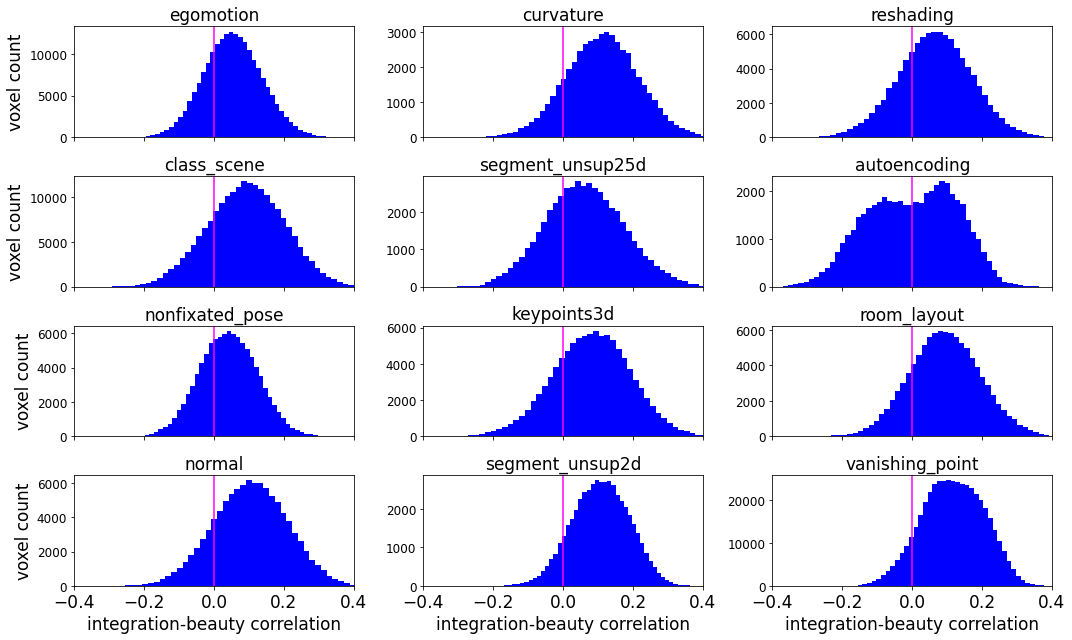

In [876]:
fig, axes = plt.subplots(4, 3, figsize=(15, 9), sharex=True, sharey=False)

for idx, mo, ax in zip(range(12), _models_ordered[::-1], axes.flat):
    if idx in (0, 3, 6, 9):
        ax.set_ylabel("voxel count")
    if idx in (9, 10, 11):
        ax.set_xlabel("integration-beauty correlation")

    subset_correlations.loc[mo].correlation.hist(bins=50, ax=ax, color="blue")
    ax.set_title(mo)
    ax.grid(visible=False)
    ax.axvline(color="magenta")
    ax.set_xlim(-0.4, 0.4)
fig.tight_layout()

## ammount of highly predictive subsets

In [349]:
subset_significance_ratio = (
    subset_significance.groupby("model").sum()
    / subset_significance.groupby("model").count()
)

Text(0.5, 0, 'ratio of significant voxels after MCC')

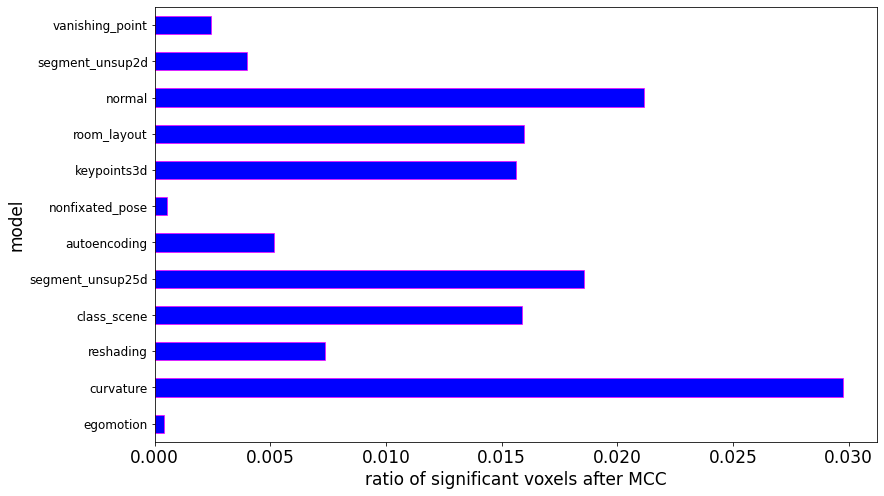

In [875]:
ax = subset_significance_ratio[_models_ordered[::-1]].plot.barh(
    color="blue", ec="magenta", linewidth=0.7, figsize=(8 * 1.618, 8)
)
ax.set_xlabel("ratio of significant voxels after MCC")

In [877]:
# compare localized integration and full integration

# map to 3D space

In [ ]:
def run_mapsinglevoxelto3d(study, scale, model, layer, value):
    """Wrappern for map_singlevoxel_to_3d that handles saving and loading data
    Choose between mapping correlation or pvalue.

    """
    if value == "correlation":
        path = PATH_3DCORR

    if value == "pvalue":
        path = PATH_3DPVAL

    with open(
        os.path.join(path, scale, study + " " + model + " " + str(layer) + ".npy"),
        "wb",
    ) as file:
        np.save(
            file,
            map_singlevoxel_to_3d_(
                pd.read_hdf(
                    os.path.join(
                        PATH_SSIBC,
                        scale,
                        study + " " + model + " " + str(layer) + ".h5",
                    ),
                    key="subset_ibcorr",
                )[value],
                layer,
            ),
        )

## single voxel pvalues

all single models for cluster analysis <br> for p values, this is only feasible way since adding pvalues in cummolative way (as in mapping version below) makes no sense

### testing

In [5]:
scale = "scale2"
model = "reshading"
layer = 20
study = "study1"

In [15]:
df_subsetibc = pd.read_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)
df_subsetibc

,correlation,pvalue
0,-0.089326,0.159101
1,-0.117885,0.062733
2,-0.154499,0.014473
3,-0.214258,0.000649
4,-0.219570,0.000470
...,...,...
24691,-0.107042,0.091246
24692,-0.127143,0.044601
24693,-0.143033,0.023706
24694,-0.120673,0.056727


In [17]:
df_subsetibc.shape[0]

24696

In [7]:
activation_extractor, layername = setup_singlelayer(model, layer)
dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(study), scale))
activation_shape = (
    list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape
)
pat = PatternGeneratorSearchlight(
    activation_shape,
    layername,
)
ns = NetworkScorer({layername: activation_shape})

In [ ]:
singlescores3d = np.zeros(activation_shape)

for idx, score in enumerate(scores):
    singlescores3d[
        PatternGeneratorSearchlight._posnum_to_3Dindex(idx, activation_shape)
    ] = score

### scale2

In [43]:
scale = "scale2"
model = "reshading"
layer = 20

In [45]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [46]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [47]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

### scale4

In [178]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [179]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [180]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [181]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [182]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

### scale 8

In [196]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [197]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [198]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [199]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

### scale16

In [194]:
scale = "scale16"
model = "segment_unsup25d"
layer = 32

In [ ]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

## single voxel ibcorr

### scale2

In [ ]:
scale = "scale2"
model = "reshading"
layer = 20

In [136]:
run_mapsinglevoxelto3d("study1", scale, model, layer, "correlation")

In [137]:
run_mapsinglevoxelto3d("study2", scale, model, layer, "correlation")

In [138]:
run_mapsinglevoxelto3d("study3", scale, model, layer, "correlation")

In [ ]:
run_mapsinglevoxelto3d("study4", scale, model, layer, "correlation")

# map to 3D space: cumulative correlation
from each voxel inside 3x3x3 box aroung location 

In [ ]:
scores = subset_correlations.loc[mo].correlation.values

In [ ]:
scores = subset_correlations.loc[mo].correlation.values[:, np.newaxis].T

In [ ]:
scores[~subset_significance.loc[mo].values] = 0

In [ ]:
subset_correlations.loc[mo].pvalue.values

In [ ]:
ns.map_back_scores(scores, pat)

In [ ]:
scores3d = list(ns.scores.values())[0]

# (old) calculate cluster permutation distributions
cluster based permutation testing, at each scale  & study

In [4]:
# permutation test size for all tets
n_permutations = 1000

In [7]:
def run_calculateclusters(scale, model, layer, study, n_permutations):
    """
    Wrapper around permutation_distribution() that handles
    loading input and saving output for the given data.

    """
    with open(
        os.path.join(
            PATH_PERMDISTR,
            scale,
            "permdistr " + study + " " + model + " " + str(layer) + ".npy",
        ),
        "wb",
    ) as file:
        np.save(
            file,
            permutation_distribtion(
                pd.read_hdf(
                    os.path.join(
                        PATH_SSINT,
                        scale,
                        study2dataset(study) + " " + model + " " + str(layer) + ".h5",
                    ),
                    key="subset integration",
                ),
                studyratings(study),
                layer,
                n_permutations,
            ),
        )

## scale2

In [50]:
scale = "scale2"
model = "reshading"
layer = 20

In [ ]:
run_calculateclusters(scale, model, layer, "study1", n_permutations)

In [ ]:
# due to key being with and underscore in this one!!!
study = "study3"
with open(
    os.path.join(
        PATH_PERMDISTR,
        scale,
        "permdistr " + study + " " + model + " " + str(layer) + ".npy",
    ),
    "wb",
) as file:
    np.save(
        file,
        permutation_distribtion(
            pd.read_hdf(
                os.path.join(
                    PATH_SSINT,
                    scale,
                    study2dataset(study) + " " + model + " " + str(layer) + ".h5",
                ),
                key="subset_integration",
            ),
            studyratings(study),
            layer,
            n_permutations,
        ),
    )

In [ ]:
run_calculateclusters(scale, model, layer, "study3", n_permutations)

In [ ]:
#run_calculateclusters(scale, model, layer, "study4", n_permutations)

## scale4

In [55]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [ ]:
run_calculateclusters(scale, model, layer, "study1", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study2", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study3", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study4", n_permutations)

## scale8

In [59]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [ ]:
run_calculateclusters(scale, model, layer, "study1", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study2", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study3", n_permutations)

In [ ]:
#run_calculateclusters(scale, model, layer, "study4", n_permutations)

## scale16

In [ ]:
scale = "scale16"
model = "segment_unsup25d"
layer = 32

In [ ]:
run_calculateclusters(scale, model, layer, "study1", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study2", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study3", n_permutations)

In [ ]:
run_calculateclusters(scale, model, layer, "study4", n_permutations)

# filter clusters from 3D data

In [ ]:
# import permutation distribution
# calculate threshold of significant cluster size

# import 3d data
# calculate clusters in 3d data (existing function)
# calculate size of each cluster
# threshold clusters that are significant

# save significant clusters (need them in 3d-plot as well as robustness analysis)

## functions

#### filter top voxels

#### find clusters

In [ ]:
def find_clusters(spatial_distribution):
    """
    Find clusters in give 3D array

    Parameters
    ----------
    spatial_distribution: np.array
        Boolean array of spatial distribution in which to find any clusters.

    """
    dims = spatial_distribution.shape
    visited = np.zeros(dims, dtype=bool)
    clusters = []
    structure = np.ones((3, 3, 3), dtype=bool)

    for x, y, z in product(range(dims[0]), range(dims[1]), range(dims[2])):

        if spatial_distribution[x, y, z] and not visited[x, y, z]:
            # update cluster labels
            labeled_array, num_features = label(
                spatial_distribution & ~visited, structure=structure
            )
            # get label of cluster at this location
            cluster_idx = labeled_array[x, y, z]

            # cluster indeed exists
            if cluster_idx > 0:
                cluster_mask = labeled_array == cluster_idx
                visited[cluster_mask] = True
                # cluster is not just single voxel
                if cluster_mask.sum() > 1:
                    cluster_array = np.zeros_like(spatial_distribution)
                    # save map of this cluster
                    cluster_array[cluster_mask] = True
                    clusters.append(cluster_array)

    return clusters

#### cluster size permutation distribution

In [ ]:
# permutation test size for all tets
n_permutations = 1000
def run_permutationdistribition(scale, model, layer, study, n_permutations):
    """
    Wrapper around permutation_distribution() that handles
    loading input and saving output for the given data.

    Calculates permutation distribution of cluster sizes by shuffling image ratings.

    """
    with open(
        os.path.join(
            PATH_PERMDISTR,
            scale,
            "permdistr " + study + " " + model + " " + str(layer) + ".npy",
        ),
        "wb",
    ) as file:
        np.save(
            file,
            permutation_distribtion(
                pd.read_hdf(
                    os.path.join(
                        PATH_SSINT,
                        scale,
                        study2dataset(study) + " " + model + " " + str(layer) + ".h5",
                    ),
                    key="subset integration",
                ),
                studyratings(study),
                layer,
                n_permutations,
            ),
        )

## any .05 significant voxels
not exclusively very highly predictive voxels <br>

These give very large clsuters about 1/3 of all voxels. Which is not very meaningfull.

In [64]:
scale = "scale2"
model = "reshading"
layer = 20

In [66]:
study = "study1"
with open(
    os.path.join(
        PATH_PERMDISTR,
        scale,
        "permdistr " + study + " " + model + " " + str(layer) + ".npy",
    ),
    "rb",
) as file:
    permdistr = np.load(file)

(array([ 77., 243., 242., 225.,  98.,  52.,  33.,  20.,   3.,   1.,   1.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([10.  , 13.05, 16.1 , 19.15, 22.2 , 25.25, 28.3 , 31.35, 34.4 ,
        37.45, 40.5 , 43.55, 46.6 , 49.65, 52.7 , 55.75, 58.8 , 61.85,
        64.9 , 67.95, 71.  ]),
 <a list of 20 Patch objects>)

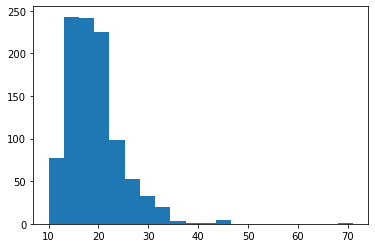

In [88]:
plt.hist(permdistr, bins=20)

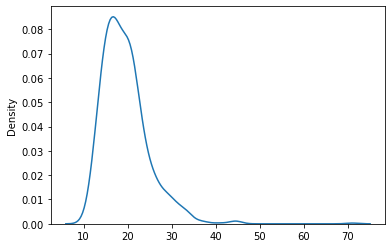

In [83]:
sns.kdeplot(permdistr)

In [91]:
threshold = np.quantile(permdistr, .95)
threshold

29.049999999999955

In [97]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    data3d = np.load(file)

In [98]:
data3d.shape

(126, 14, 14)

In [104]:
clusters = find_clusters(data3d<.05)

In [106]:
len(clusters)

12

In [112]:
126*14*14

24696

In [111]:
clusters[0].shape

(126, 14, 14)

In [124]:
# clusters above threshold
[cluster.sum() for cluster in clusters if cluster.sum() > threshold]

[8655, 941, 2310]

## highly predictive voxels

In [ ]:
# relative ammount (e.g. top 10% of voxels)
# input 3d array of ibcorr

In [ ]:
# current: calculate overlap over top10% voxels

# add: filtering of top 10% voxels for to only contain voxels in clusters
#   because: thesis says that there is localization and that that localization is robust

#   input: thresholded 3d ibcorr
#   calculate significant clusters (same code as with pvalues)
#   calculate overlap between significant clusters
#   apply across studies and scales, maybe make a single table/RDM of overlap for the studies of each scale


# optional: visualize (write function that takes 3d array as input and plots, if necessary multiple plots, with each about 60-80 convulutional filters at once)

In [ ]:
# functions
# filter top X% voxels
# in 3dmap of ibcorr (float)
# out 3d map of top X% predictive voxels (bool)

# calculate threshold:
# calculate cluster distribution (function)
# take 95% quantile

# filter clusters
# in 3d map of voxels (bool), threshold (from permuation test or manually)
# out 3d map of voxels (bool), but only those in significant clusters

# do this for each study
# caluculate overlap coefficient for each combintation
# plot each combination
# talk to daniel how to do significance testing

#

### ibcorr from whole layers

In [147]:
dfibc.loc[("reshading", slice(None), "scale2", 20)]

,ibcorr
study,
short presentation,0.405152
long presentation,0.377791
complexity order,0.366724
oasis,0.160978


In [148]:
dfibc.loc[("segment_unsup2d", slice(None), "scale4", 41)]

,ibcorr
study,
short presentation,0.464074
long presentation,0.441788
complexity order,0.359942
oasis,0.122006


In [150]:
dfibc.loc[("vanishing_point", slice(None), "scale8", 18)]

,ibcorr
study,
short presentation,0.440726
long presentation,0.364254
complexity order,0.397447
oasis,0.166637


In [151]:
dfibc.loc[("segment_unsup25d", slice(None), "scale16", 32)]

,ibcorr
study,
short presentation,0.363642
long presentation,0.342855
complexity order,0.376884
oasis,0.101665


### overlap of top 10% of (unclustered) predictive voxels

In [152]:
scale = "scale2"
model = "reshading"
layer = 20

In [171]:
study = "study1"

with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    # flipping of sign is currently missing in calculation of integration
    corr3d_st1 = -np.load(file)

In [199]:
study = "study2"

with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    # flipping of sign is currently missing in calculation of integration
    corr3d_st2 = -np.load(file)

In [201]:
study = "study3"

with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    # flipping of sign is currently missing in calculation of integration
    corr3d_st3 = -np.load(file)

In [177]:
q90_st1 = np.quantile(corr3d_st1.flatten(), .9)
q90_st1

0.2331098471729129

In [178]:
q90_st2 = np.quantile(corr3d_st2.flatten(), .9)
q90_st2

0.21450488659343914

In [202]:
q90_st3 = np.quantile(corr3d_st3.flatten(), .9)
q90_st3

0.23174331077878463

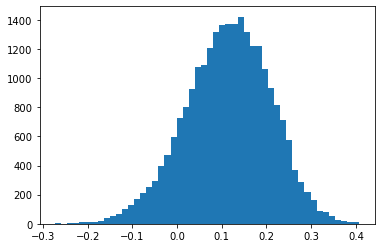

In [175]:
plt.hist(corr3d_st1.flatten(), bins=50);

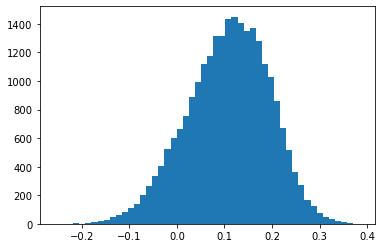

In [176]:
plt.hist(corr3d_st2.flatten(), bins=50);

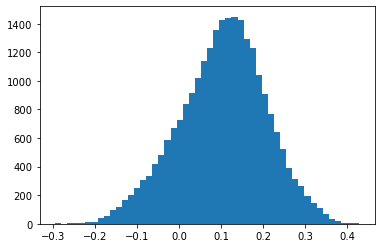

In [203]:
plt.hist(corr3d_st3.flatten(), bins=50);

In [181]:
m1 = corr3d_st1>q90_st1

In [194]:
m2 = corr3d_st2>q90_st2

In [204]:
m3 = corr3d_st3>q90_st3

In [191]:
m1.shape, 126*14*14

((126, 14, 14), 24696)

In [217]:
# this may be rougly the shape of a large cluster of highly predictive voxels
100*5*5

2500

In [192]:
m1.sum()

2470

In [195]:
m2.sum()

2470

In [205]:
m3.sum()

2470

In [197]:
(m1 & m2).sum()

1608

In [206]:
(m1 & m3).sum()

910

In [208]:
(m2 & m3).sum()

764

In [ ]:
# significant overlap: permutation testing
# permutation: how much do cluters from randomized scores overlap ?

In [220]:
m1.shape

(126, 14, 14)

# 3D-plot


## function

In [274]:
def plot_3dvoxels_twoarrays(arr1, arr2, study1, study2, scale, model, layer, alpha = 1.):
    with PdfPages(
        os.path.join(
            PATH_RESULTS,
            "spatial integration",
            "3D plots",
            scale,
            model + " " + study1 + " vs " + study2 + " | layer "+ str(layer) + ".pdf",
        )
    ) as pdf:

        for i in range(0, arr1.shape[0], 25):
            ax = plt.figure(figsize=(16, 10)).add_subplot(projection="3d")
            ax.voxels(arr1[i : i + 25].astype(bool), facecolors="magenta", alpha=alpha)
            ax.voxels(arr2[i : i + 25].astype(bool), facecolors="blue", alpha=alpha)

            pdf.savefig()
            plt.close()

In [272]:
scale = "scale2"
model = "reshading"
layer = 20

In [278]:
plot_3dvoxels_twoarrays(m1, m2, "study1", "study2", scale, model, layer, alpha=.385)

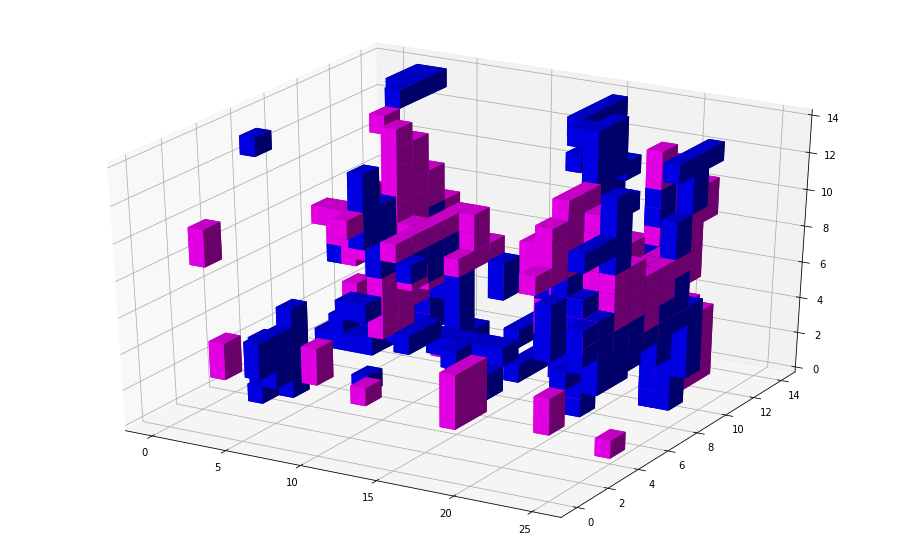

In [250]:
ax = plt.figure(figsize=(16, 10)).add_subplot(projection="3d")
ax.voxels(m1[:25].astype(bool), facecolors="magenta");
ax.voxels(m3[:25].astype(bool), facecolors="blue");


## clusters

In [727]:
with PdfPages(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "subset ibcorr 3dplots",
        "study3 scale4",
        "significant singlescores" + mo + ".pdf",
    )
) as pdf:
    for i in range(scores3d.shape[0]):
        sns.heatmap(singlescores3d[i, :, :])
        pdf.savefig()
        plt.close()

In [ ]:
ax = plt.figure().add_subplot(projection="3d")
ax.voxels(
    r,
    g,
    b,
    sphere,
    facecolors=colors,
    edgecolors=np.clip(2 * colors - 0.5, 0, 1),  # brighter
    linewidth=0.5,
)

In [760]:
singlescores3d.shape[:20]

(256, 16, 16)

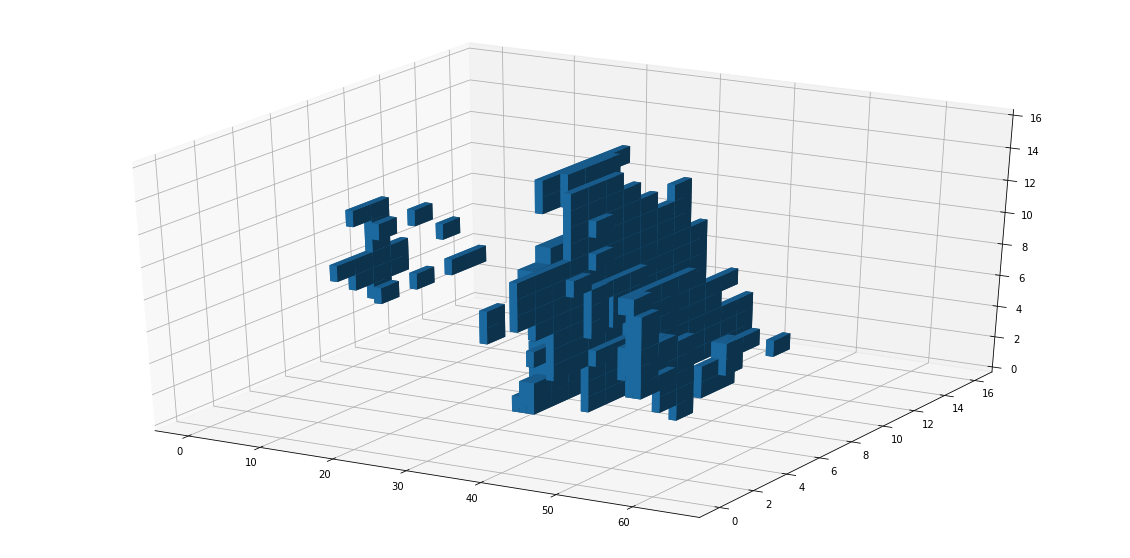

In [781]:
ax = plt.figure(figsize=(20, 10)).add_subplot(projection="3d")
ax.voxels(singlescores3d[:64].astype(bool))

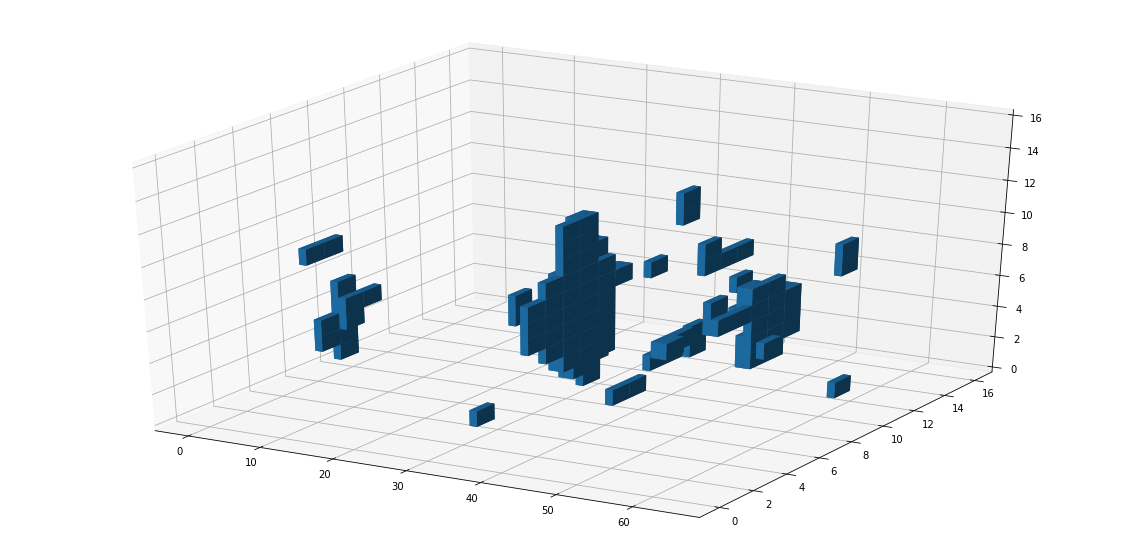

In [782]:
ax = plt.figure(figsize=(20, 10)).add_subplot(projection="3d")
ax.voxels(singlescores3d[64:128].astype(bool))

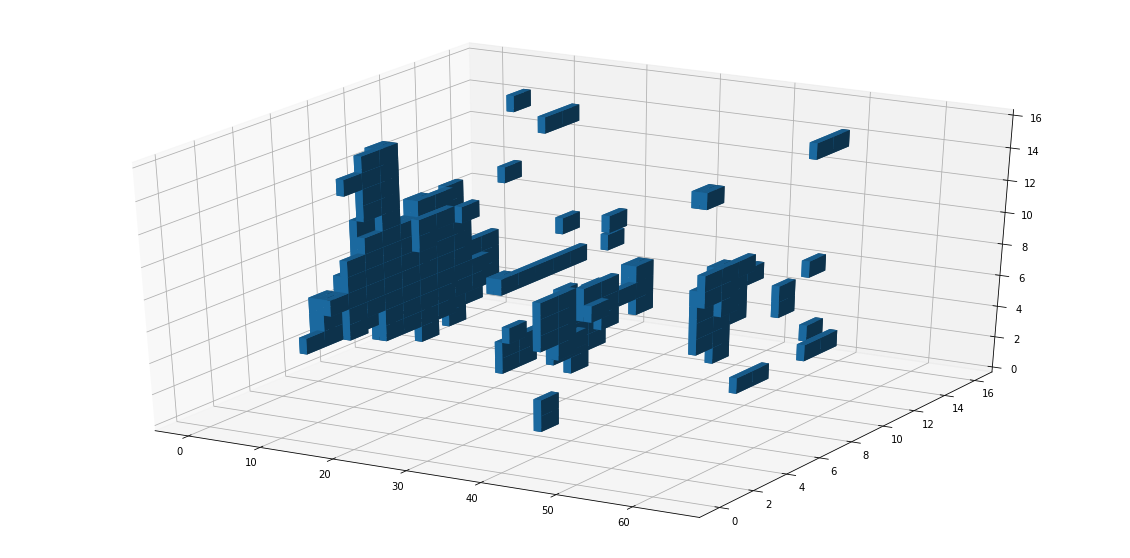

In [783]:
ax = plt.figure(figsize=(20, 10)).add_subplot(projection="3d")
ax.voxels(singlescores3d[128 : 128 + 64].astype(bool))

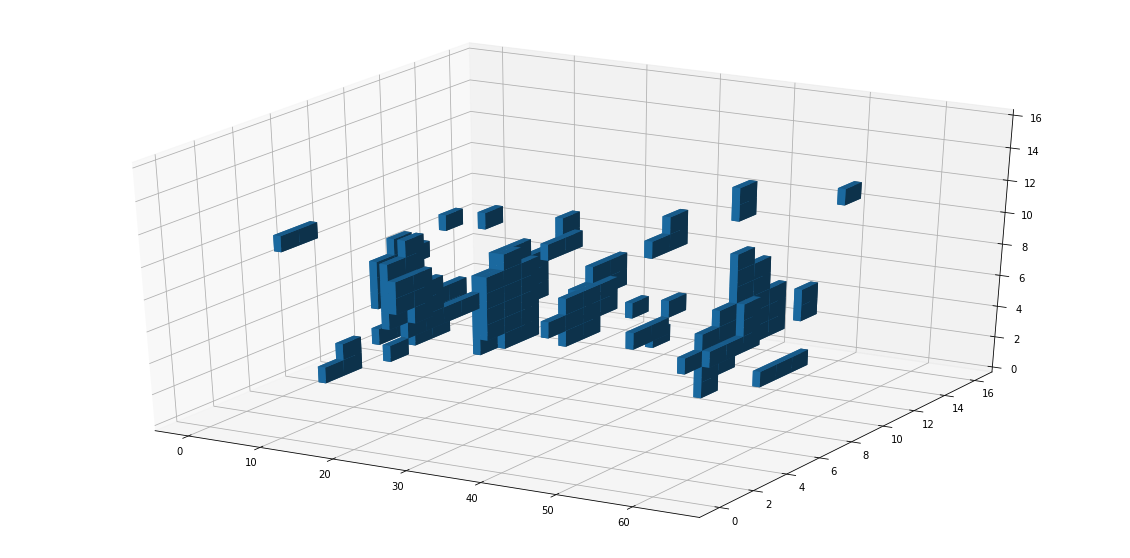

In [784]:
ax = plt.figure(figsize=(20, 10)).add_subplot(projection="3d")
ax.voxels(singlescores3d[128 + 64 :].astype(bool))

In [ ]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

# localized ibcorr outperforms whole layer ibcorr
still need to include comapre correlations ?

In [ ]:
rat = beauty_ratings["study3_places2.csv"].values.flatten()

In [ ]:
dfibc = load_ibcorr(PATH_IBCORR)

In [ ]:
subset_correlations.correlation.groupby("model").max()

model
autoencoding        0.362207
class_scene         0.480581
curvature           0.455136
egomotion           0.371716
keypoints3d         0.460132
nonfixated_pose     0.401111
normal              0.503802
reshading           0.458294
room_layout         0.483429
segment_unsup25d    0.469479
segment_unsup2d     0.374942
vanishing_point     0.416983
Name: correlation, dtype: float64

In [ ]:
dfibc.loc[(_models_ordered, "complexity order", "scale4", slice(None))].droplevel(
    ["study", "scale"]
).loc[bestlayers]

,,ibcorr
model,layer,
autoencoding,25,0.252745
class_scene,36,0.386861
curvature,32,0.480282
egomotion,33,0.280207
keypoints3d,41,0.441996
nonfixated_pose,41,0.280803
normal,41,0.419579
reshading,46,0.454562
room_layout,41,0.424132


In [ ]:
bestlayers = (
    dfibc.loc[(_models_ordered, "complexity order", "scale4", slice(None))]
    .droplevel(["study", "scale"])
    .groupby("model")
    .idxmax()
    .ibcorr.map(lambda x: x[1])
    .to_frame()
    .reset_index()
    .values.tolist()
)

In [ ]:
bestlayers = (
    dfibc.loc[(_models_ordered, "complexity order", "scale4", slice(None))]
    .droplevel(["study", "scale"])
    .groupby("model")
    .idxmax()
    .ibcorr.map(lambda x: x[1])
    .to_frame()
)

# cluster robustness